In [1]:
import numpy as np
import pandas as pd
import os
import re
import astropy.units as u
import sys
import multiprocessing as mp
import tqdm

import seaborn as sn
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('figure', facecolor='none')
rc('xtick', labelsize=30)
rc('ytick', labelsize=30)
mpl.rcParams['axes.linewidth'] = 1.2

import vplanet_inference as vpi
sys.path.append(os.path.realpath("../src"))

In [2]:
inpath = os.path.join(vpi.INFILE_DIR, "stellar_eqtide/cpl")

inparams = {
            "primary.dMass": u.Msun, 
            "secondary.dMass": u.Msun, 
            "primary.dRotPeriod": u.day, 
            "secondary.dRotPeriod": u.day, 
            "primary.dTidalQ": u.dex(u.s), 
            "secondary.dTidalQ": u.dex(u.s), 
            "secondary.dEcc": u.dimensionless_unscaled, 
            "secondary.dOrbPeriod": u.day,
            "vpl.dStopTime": u.Gyr
}

outparams = {
             "final.primary.RotPer": u.day, 
             "final.secondary.Eccentricity": u.dimensionless_unscaled,
             "final.secondary.OrbPeriod": u.day,
             "final.secondary.RotPer": u.day
}

cpl = vpi.VplanetModel(inparams, inpath=inpath, outparams=outparams, 
                       verbose=False, timesteps=1e6*u.yr, time_init=5e6*u.yr)

In [4]:
os.listdir("../analysis/results_likelihood_1d/cpl_stellar_eqtide/results/full_likelihood/1param_cpl_10_myr/")

['tide_4', 'tide_5', 'tide_6', 'tide_7', 'tide_8']

In [5]:
def find_peaks(age, tide="6", tsplit=-1.5):
    sims = np.load(f"../analysis/results_likelihood_1d/cpl_stellar_eqtide/results/full_likelihood/1param_cpl_{age}_myr/tide_{tide}/tide_likelihood_sample.npz")

    tt = sims['theta'].T[0]
    y = sims['y']

    idx = np.where(tt < tsplit)[0]
    tpeak1 = tt[idx][np.argmax(y[idx])]

    idx = np.where(tt > tsplit)[0]
    tpeak2 = tt[idx][np.argmax(y[idx])]
    
    return tt, y, tpeak1, tpeak2

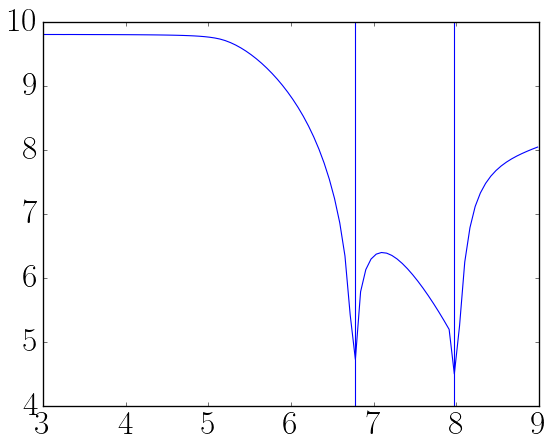

In [7]:
# tt, y, tpeak50, _ = find_peaks(50, tide="8", tsplit=-1.5)
# tt, y, tpeak500, _ = find_peaks(500, tide="0", tsplit=-1.5)
tt, y, tpeak1, tpeak2 = find_peaks(5000, tide="8", tsplit=7.5)

plt.plot(tt, np.log10(-y))
plt.axvline(tpeak1)
plt.axvline(tpeak2)
plt.show()

In [9]:
def tsub(qval):
    ttrue = {"primary.dMass": 1.0, 
            "secondary.dMass": 1.0, 
            "primary.dRotPeriod": 0.5, 
            "secondary.dRotPeriod": 0.5, 
            "primary.dTidalQ": qval, 
            "secondary.dTidalQ": qval, 
            "secondary.dEcc": 0.15, 
            "secondary.dOrbPeriod": 7.0,
            "vpl.dStopTime": 10
            }
    return list(ttrue.values())

sim0 = cpl.run_model(tsub(8.))
sim1 = cpl.run_model(tsub(tpeak1))
sim2 = cpl.run_model(tsub(tpeak2))

peaks = [tpeak1, tpeak2]

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

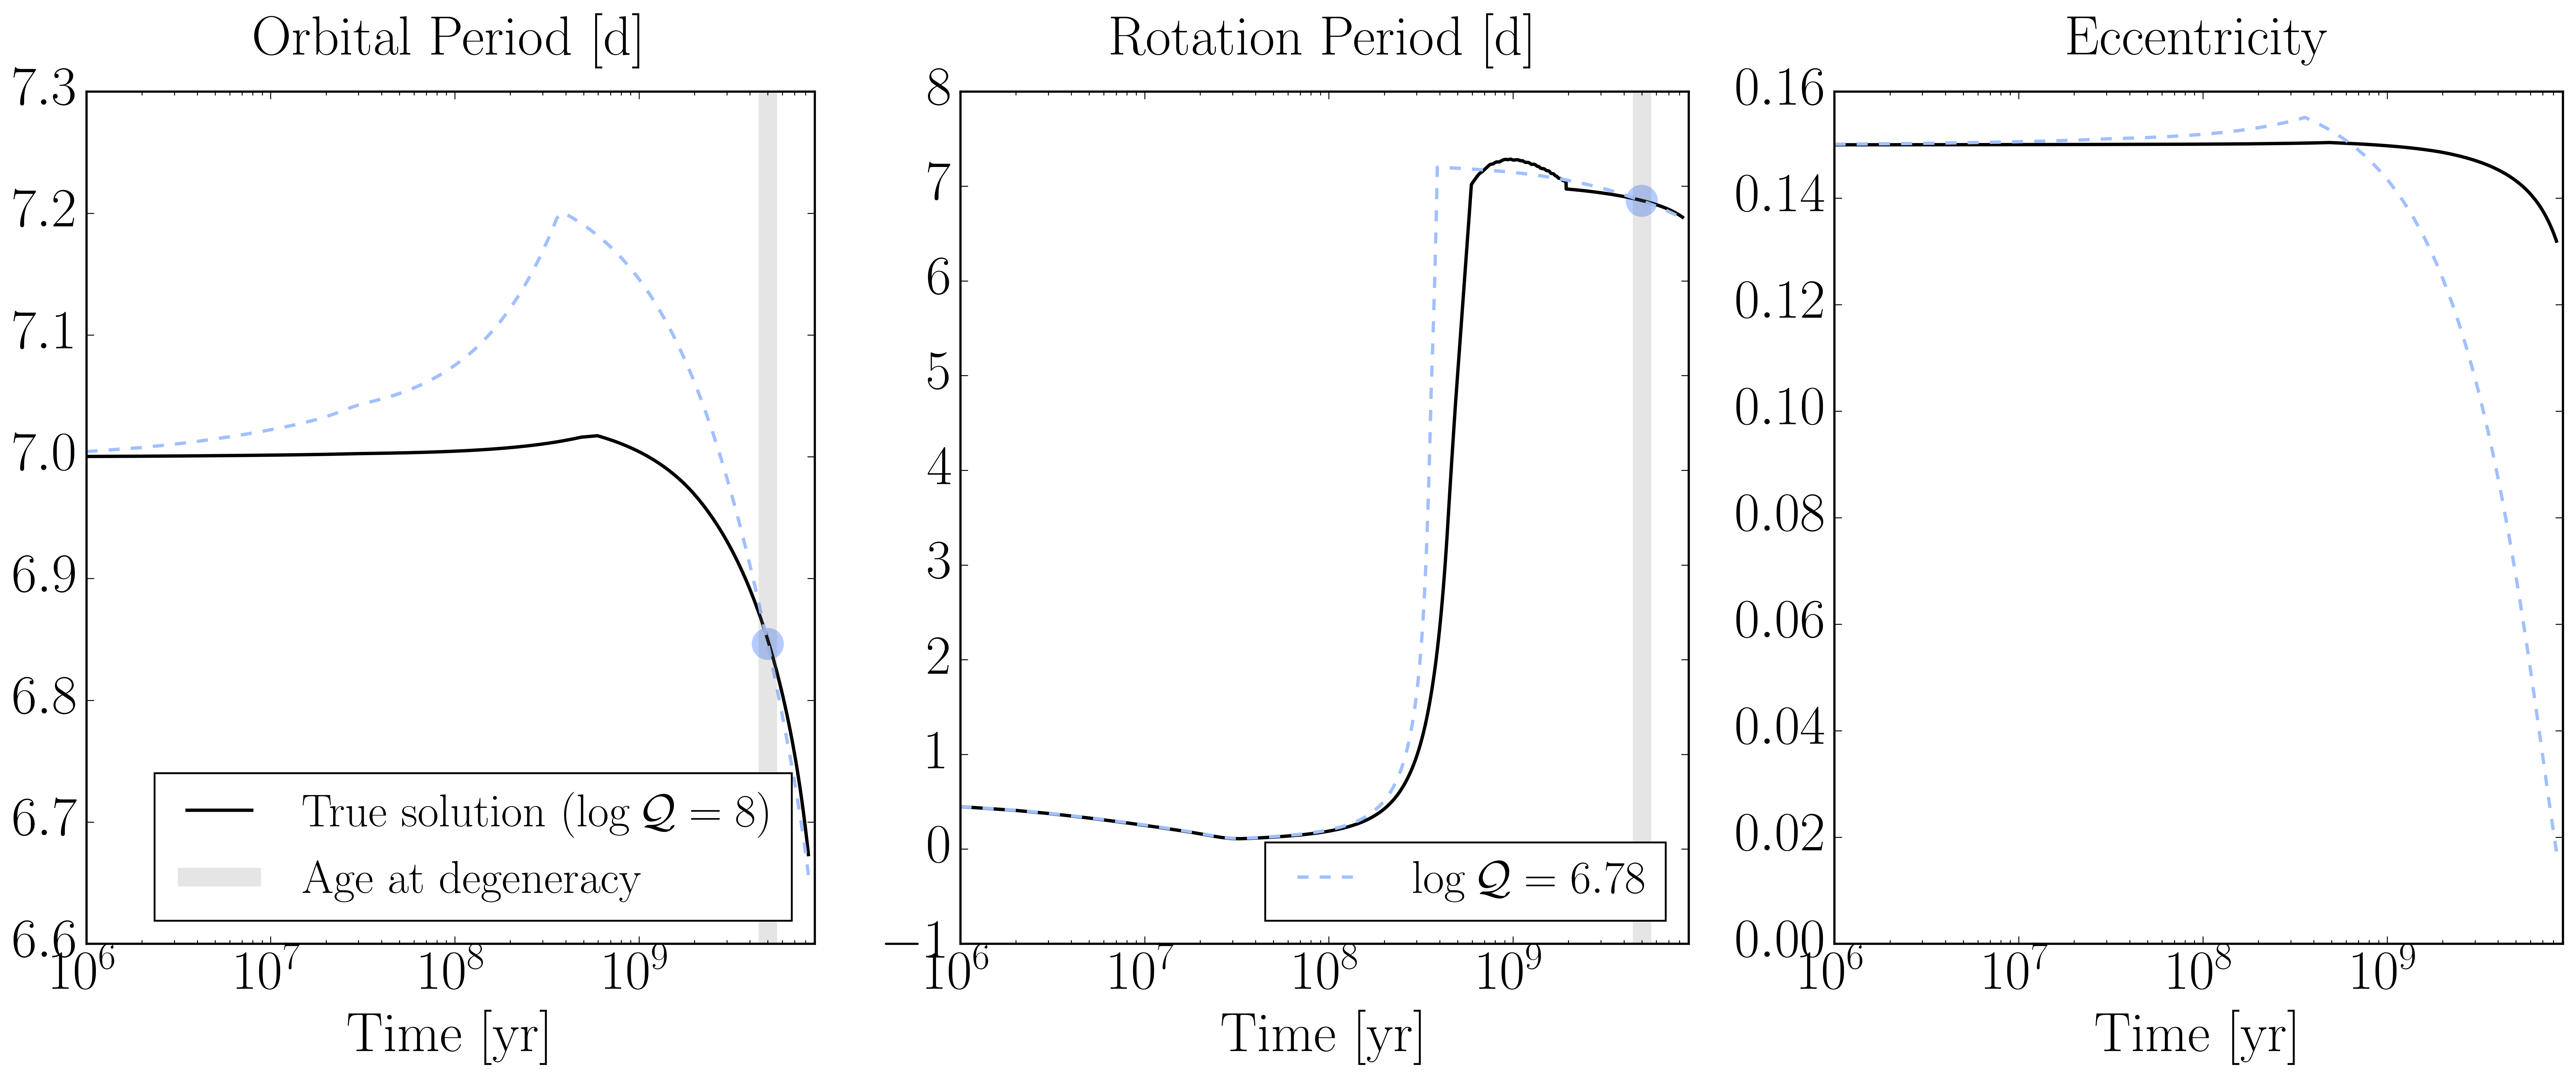

In [27]:
fig, axs = plt.subplots(1, 3, figsize=[24,8], sharex=True, dpi=500)

lw = 1.8
c1 = "k"
c2 = "g"
c3 = "grey"

cmap = mpl.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin=4, vmax=8)
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cmap.set_array([])
colors = [cmap.to_rgba(pk) for pk in peaks]

axs[0].plot(sim0["Time"], sim0["final.secondary.OrbPeriod"], lw=lw, color=c1, label=r"True solution ($\log\mathcal{Q}=8$)")
axs[1].plot(sim0["Time"], sim0["final.primary.RotPer"], lw=lw, color=c1)
axs[2].plot(sim0["Time"], sim0["final.secondary.Eccentricity"], lw=lw, color=c1)

axs[0].plot(sim1["Time"], sim1["final.secondary.OrbPeriod"], linestyle="--", lw=lw, color=colors[0])
axs[1].plot(sim1["Time"], sim1["final.primary.RotPer"], linestyle="--", lw=lw, color=colors[0], label=r"$\log\mathcal{Q}=%s$"%(round(tpeak1,2)))
axs[2].plot(sim1["Time"], sim1["final.secondary.Eccentricity"], linestyle="--", lw=lw, color=colors[0])


axs[0].scatter(5e9, sim1["final.secondary.OrbPeriod"][find_nearest(sim1["Time"], 5e9)], s=300, edgecolor="none", facecolor=colors[0], alpha=.8)
axs[1].scatter(5e9, sim1["final.secondary.RotPer"][find_nearest(sim1["Time"], 5e9)], s=300, edgecolor="none", facecolor=colors[0], alpha=.8)


axs[0].axvline(5000*1e6, linewidth=10, alpha=.2, color=c3, label="Age at degeneracy")
axs[1].axvline(5000*1e6, linewidth=10, alpha=.2, color=c3)

axs[0].set_title("Orbital Period [d]", fontsize=30, pad=20)
axs[1].set_title("Rotation Period [d]", fontsize=30, pad=20)
axs[2].set_title("Eccentricity", fontsize=30, pad=20)

axs[0].set_xlabel('Time [yr]', fontsize=30)
axs[1].set_xlabel('Time [yr]', fontsize=30)
axs[2].set_xlabel('Time [yr]', fontsize=30)

axs[0].legend(loc="lower right", fontsize=25)
axs[1].legend(loc="lower right", fontsize=25)

axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[2].set_xscale("log")
axs[0].set_xlim(1e6, 9e9)
plt.savefig("/home/jbirky/Dropbox/Apps/Overleaf/Binary_Tides/figures/1d_degeneracy_evolution_q_8.png", bbox_inches="tight")
plt.show()

In [18]:
sim3 = cpl.run_model(tsub(4.))
sim4 = cpl.run_model(tsub(5.))

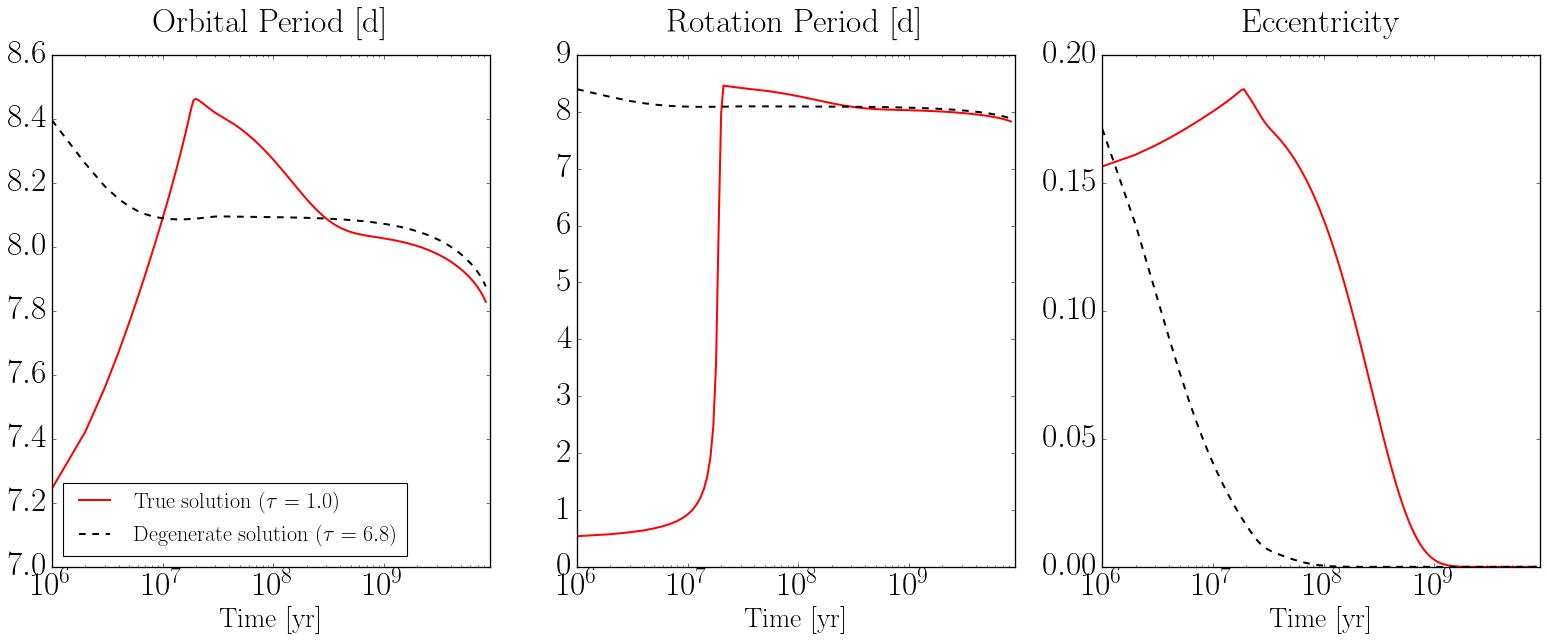

In [20]:
fig, axs = plt.subplots(1, 3, figsize=[24,8], sharex=True)

lw = 1.8
c2 = "r"
c1 = "k"
axs[0].plot(sim4["Time"], sim4["final.secondary.OrbPeriod"], lw=lw, color=c2, label=r"True solution ($\tau=1.0$)")
axs[1].plot(sim4["Time"], sim4["final.primary.RotPer"], lw=lw, color=c2)
axs[2].plot(sim4["Time"], sim4["final.secondary.Eccentricity"], lw=lw, color=c2)

axs[0].plot(sim3["Time"], sim3["final.secondary.OrbPeriod"], linestyle="--", lw=lw, color=c1, label=r"Degenerate solution ($\tau=%s$)"%(round(tpeak1,1)))
axs[1].plot(sim3["Time"], sim3["final.primary.RotPer"], linestyle="--", lw=lw, color=c1)
axs[2].plot(sim3["Time"], sim3["final.secondary.Eccentricity"], linestyle="--", lw=lw, color=c1)

axs[0].set_title("Orbital Period [d]", fontsize=30, pad=20)
axs[1].set_title("Rotation Period [d]", fontsize=30, pad=20)
axs[2].set_title("Eccentricity", fontsize=30, pad=20)

axs[0].set_xlabel('Time [yr]', fontsize=25)
axs[1].set_xlabel('Time [yr]', fontsize=25)
axs[2].set_xlabel('Time [yr]', fontsize=25)

axs[0].legend(loc="lower left", fontsize=20)

axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[2].set_xscale("log")
axs[0].set_xlim(1e6, 9e9)
# plt.savefig("/home/jbirky/Dropbox/Apps/Overleaf/Binary_Tides/figures/1d_degeneracy_evolution_50myr.png", bbox_inches="tight")
plt.show()